# IAU - Inteligentná analýza údajov (2024/2025)

#### Autori: Jan Lenhart (50 %), Marek Čederle (50 %)
##### Cvičenie: Pondelok 15:00, Cvičiaci: Ing. Oleksandr Lytvyn

<font color='salmon'>
    <b>Upozornenie:</b>
    Runtime celého notebooku je ~1 minuta.
    Pri spúštaní notebooku sme mali nejaké problémy s kernelom resp. knižnicami. Po update na verziu pythonu 3.12.8 sa to vyriešilo ale nevieme či je reálne chyba na staršej verzii.
</font>

## Hlboké učenie (Deel Learning) - Aktivita

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import keras_tuner as kt
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import LSTM, Dropout, Dense # type: ignore
from keras.optimizers import Adam # type: ignore

Na začiatok sme si načítali dáta, ktoré sme stiahli [z kaggle](https://www.kaggle.com/datasets/aayushmishra1512/netflix-stock-data).

In [2]:
df_netflix = pd.read_csv("netflix-stock-data/NFLX.csv", delimiter=',')

### 4.1 EDA and data preprocessing

#### 4.1.A EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

Urobili sme si jednoduchú EDA, aby sme zistili základné informácie o našom datasete.

In [3]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.7+ KB


In [4]:
df_netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [5]:
df_netflix.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


In [6]:
df_netflix.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
(df_netflix['Close'] == df_netflix['Adj Close']).all()

np.True_

Môžeme si všimnúť, že máme 7 stĺpcov a 4581 riadkov. V datasete nemáme žiadne chýbajúce hodnoty. Zistili sme že stĺpec `Date` je typu `object`, preto ho musíme pretypovať na `datetime` aby sme s ním vedeli ďalej pracovať.

Keďže sme si všimli, že stĺpec `Close` a `Adj Close` sú v hlavičke datasetu rovnaké, vyskúšali sme zistiť či sú celé stĺpce rovnaké resp. všetky záznamy. Výsledok bol, že sú rovnaké, preto sme sa rozhodli odstrániť stĺpec `Adj Close` pretože by to bol len duplikát, ktorý by nám na konci mohol pri trénovaní uškodiť.

In [8]:
df_netflix = df_netflix.drop(columns=['Adj Close'])
df_netflix

,Date,Open,High,Low,Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200
...,...,...,...,...,...,...
4576,2020-07-28,496.019989,497.790009,487.760010,488.510010,5986700
4577,2020-07-29,492.250000,494.920013,484.130005,484.480011,6611800
4578,2020-07-30,480.709991,488.350006,477.510010,485.799988,6608600
4579,2020-07-31,488.290009,494.799988,484.500000,488.880005,5924300


In [9]:
df_netflix['Date'] = pd.to_datetime(df_netflix['Date'])

In [10]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4581 non-null   datetime64[ns]
 1   Open    4581 non-null   float64       
 2   High    4581 non-null   float64       
 3   Low     4581 non-null   float64       
 4   Close   4581 non-null   float64       
 5   Volume  4581 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 214.9 KB


In [11]:
# zdroj z cvicenia IAU
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    return data[(data > upper) | (data < lower)]

In [12]:
# zdroj projekt z IAU z predchádzajúcich fáz
def identify_outliers_for_all_columns(df):
    val = {}
    columns = df.select_dtypes(exclude=['object']).columns
    for column in columns:
        outlier_count = identify_outliers(df[column]).count()
        if outlier_count > 0:
            val[column] = outlier_count
    return val

In [13]:
identify_outliers_for_all_columns(df_netflix)

{'Open': np.int64(636),
 'High': np.int64(637),
 'Low': np.int64(634),
 'Close': np.int64(636),
 'Volume': np.int64(296)}

Snažili sme sa identifikovať nejakých outlierov pomocou štandartnej `IQR` metódy, aj keď nám vyšli výsledky relatívne nízke, neskôr sme si uvedomili, že toto nie je vhodné, keďže pracujeme s datasetom, ktorý má časové závislosti a práve nejaký outlier môže byť dôležitý pre náš model pretože mohlo ísť o náhly výkyv ceny akcií. Týmto pádom by sme prišli o cenné dáta, takže sme sa rozhodli outlierov neodstraňovať.

Následne sme si zobrazili, ako vlastne vyzerajú naše dáta vzhľadom na čas.

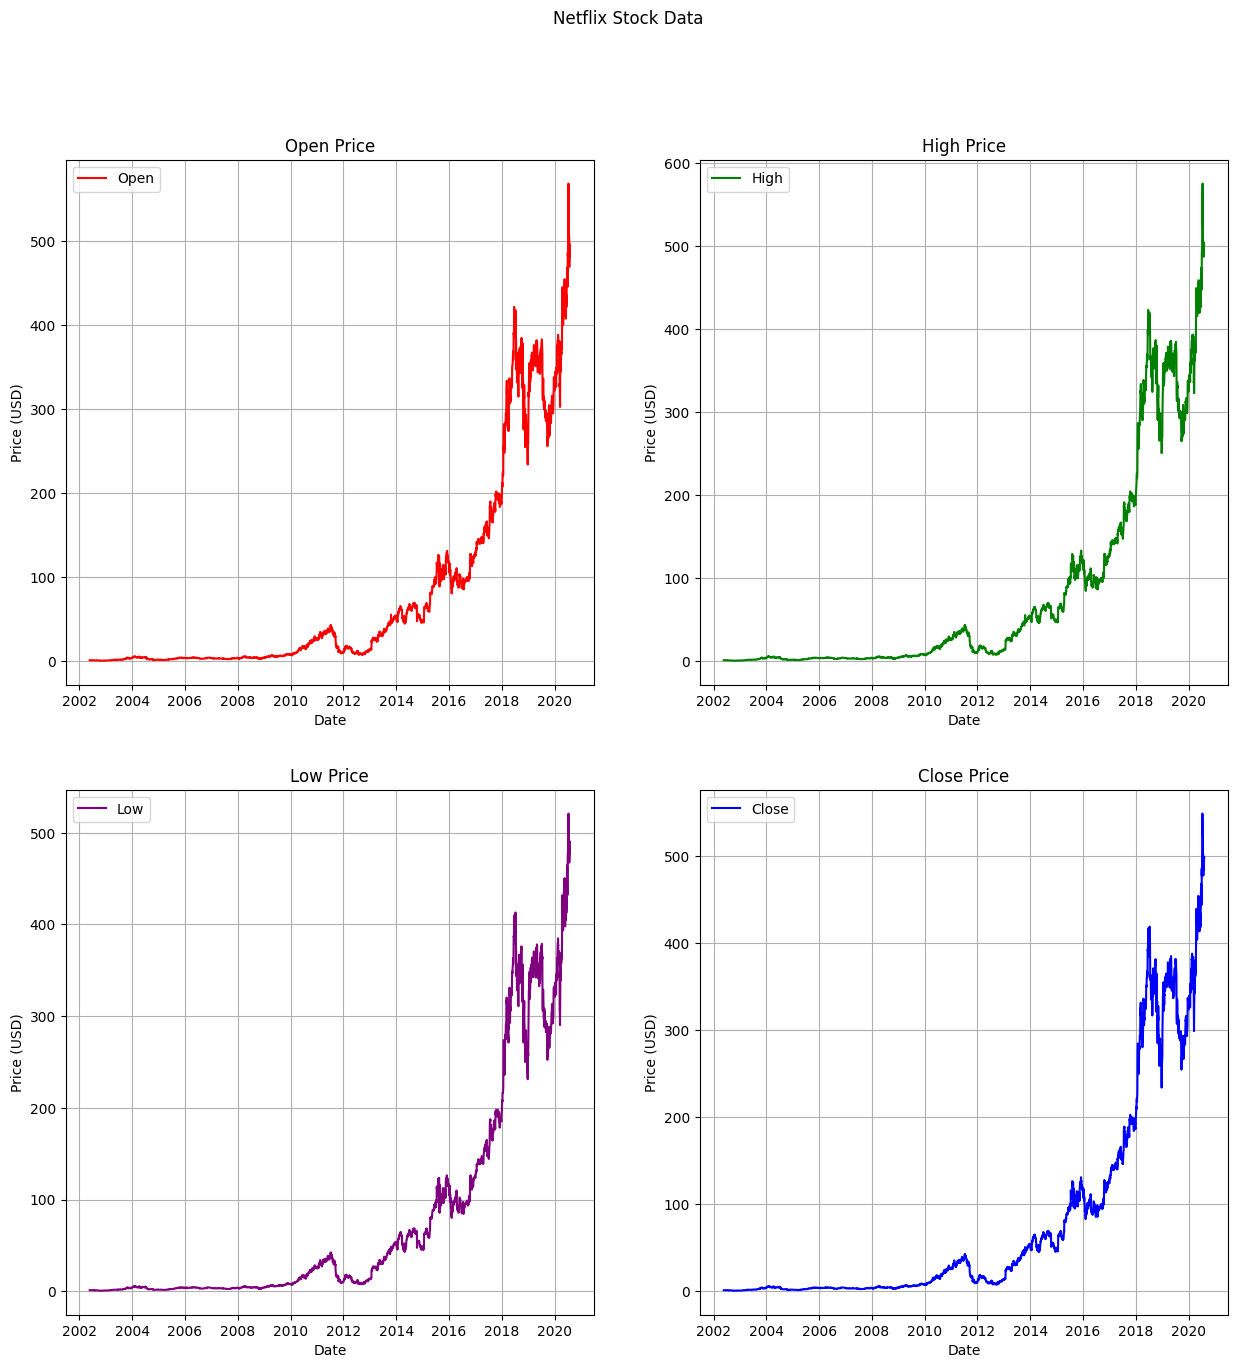

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Netflix Stock Data')
axs[0, 0].plot(df_netflix['Date'], df_netflix['Open'], label='Open', color='red')
axs[0, 0].set_title('Open Price')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price (USD)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(df_netflix['Date'], df_netflix['High'], label='High', color='green')
axs[0, 1].set_title('High Price')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price (USD)')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(df_netflix['Date'], df_netflix['Low'], label='Low', color='purple')
axs[1, 0].set_title('Low Price')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price (USD)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(df_netflix['Date'], df_netflix['Close'], label='Close', color='blue')
axs[1, 1].set_title('Close Price')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price (USD)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.show()

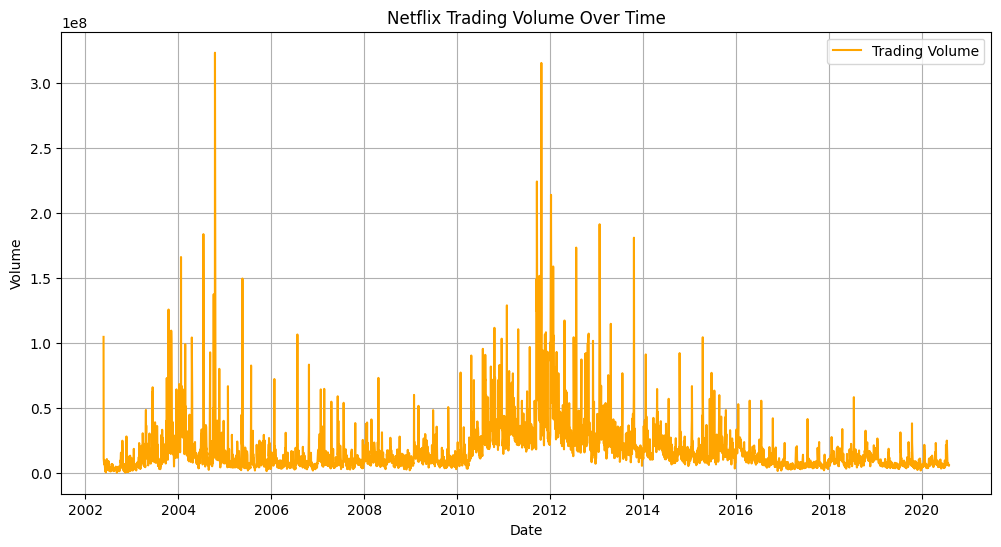

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_netflix['Date'], df_netflix['Volume'], label='Trading Volume', color='orange')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

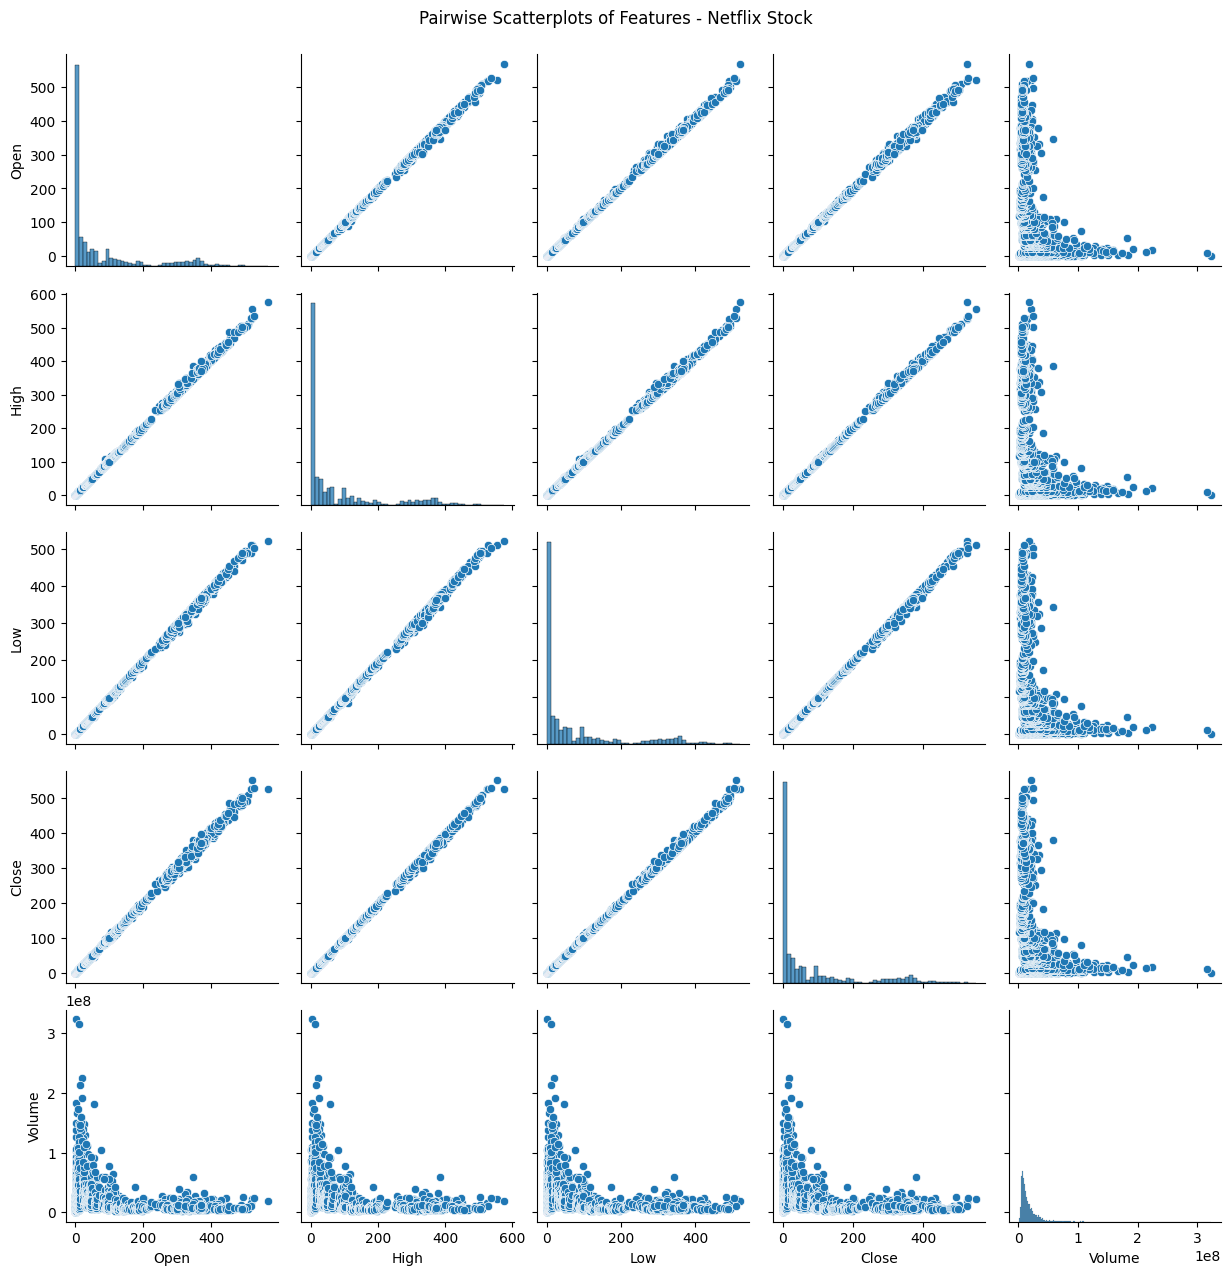

In [16]:
sns.pairplot(df_netflix[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pairwise Scatterplots of Features - Netflix Stock', y=1.02)
plt.show()

Rozhodli sme sa vyhodiť stĺpec `Volume` (resp. nepoužívať ho ako feature), pretože nám skorej ide o to, ako sa vyvýja cena akcií a teda z pohladu investora či bude trend ceny akcií rastúci alebo klesajúci.

In [17]:
features = ['Open', 'High', 'Low', 'Close']

Aby sa náš model vedel lepšie učiť, tak si normalizujeme dáta pomocou `MinMaxScaler`.

In [18]:
scaler = MinMaxScaler()
df_netflix[features] = scaler.fit_transform(df_netflix[features])

Následne sme si vytvorili tzv. `sliding window`, ktoré nám bude slúžiť na to, aby sme vedeli predikovať cenu akcií na základe predchádzajúcich dát. V našom prípade sme si zvolili veľkosť `window_size = 30`, čo znamená, že náš model sa bude snažiť predikovať cenu akcií na základe posledných 30 dní.

In [19]:
def create_sliding_windows(data, window_size=30):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [20]:
print(df_netflix.shape)

(4581, 6)


In [21]:
X, y = create_sliding_windows(df_netflix[features].values, window_size=30)

In [22]:
print(X.shape)
print(y.shape)

(4551, 30, 4)
(4551, 4)


Týmto sme síce stratili prvých 30 záznamov, ale pri veľkosti daného datasetu je to zanedbateľné a nie je úplne priamočiare ako sa to dá bez tohto trade-offu vyriešiť.

Ďalej si rozdelíme dáta na trénovaciu, validačnú a testovaciu množinu v pomere 80:10:10.

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [24]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3640, 30, 4)
(455, 30, 4)
(456, 30, 4)


#### 4.1.B Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

Naše predspracovanie dát je veľmi jednoduché kvôli tomu, že nepotrebujeme nahrádzať žiadne chýbajúce hodnoty, ani ošetrovať nejakých outlierov, stačí nám urobiť normalizáciu dát (pomocou `MinMaxScaler`). Keďže feature selection pri DL metódach robí sama neurónová sieť (resp. my sme si určili skoro všetky), tak nepotrebujeme použiť napr. `SelectKBest` ako pri ML metódach.

Keďže ide o predpovedanie ceny akcií v čase v závisloti na predchádzajúcich dátach, tak ide o tzv. `time-series forecasting`, na ktorý je vhodné použiť rekurentné neurónové siete (RNN).

### 4.2 Modeling and evaluation

#### 4.2.A Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model.

Na začiatok sme si vytvorili relatívne jednoduchí model pomocou `LSTM`, ktorý sme sa snažili manuálne optimalizovať, pričom sme menili parametre ako `units` a `batch_size`.

In [25]:
model = Sequential()

model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.2))

# dalsia testovacia vrstva, ktora nakoniec zhorsila vysledky
# model.add(LSTM(units=512, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(units=512))
model.add(Dropout(0.2))

model.add(Dense(4))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Marek\Documents\Coding\IAU\iau\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Zadefinovali sme si tzv. `EarlyStopping` objekt, ktorý slúži na to, aby sme predišli overfitu nášho modelu. Funguje tak, že ak sa za 10 epoch nezmení hodnota `val_loss`, tak zoberie model s najlepším `val_loss` čo za dobu trénovania našiel.

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Nasleduje kód, ktorý sme použili na trénovanie nášho modelu. Keďže sme boli nespokojný s výsledkami uvedenými nižšie, tak sme sa rozhodli, že použijeme jednoduchšiu alternatívu ku `LSTM` čiže `GRU` a s ňou sme ďalej pracovali.

```py
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
```

```py
y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
```

Výsledky pôvodného modelu:

| Units | Batch Size | RMSE              | MAPE               |
|-------|------------|-------------------|--------------------|
| 512   | 512        | 0.03219341919595199 | 0.03791765986358776 |
| 256   | 32         | 0.03769794454795203 | 0.0447924289643583  |
| 256   | 64         | 0.02192341983221999 | 0.025171479738628592 |
| 256   | 128        | 0.02213422756877576 | 0.025327659134866135 |
| 256   | 256        | 0.021917217489503944 | 0.0249090472434582  |
| 128   | 32         | 0.029770808433570075 | 0.0343786592317372  |
| 128   | 64         | 0.024995286606666257 | 0.02922919537650753 |
| 128   | 128        | 0.02535494649439373 | 0.02923194384640631 |
| 8     | 8          | 0.0962524559723423   | 0.12726893594999136 |
| 8     | 16         | 0.04268615461118916  | 0.048110396088238916 |
| 8     | 32         | 0.04372450315403822  | 0.05043758262638413 |
| 8     | 64         | 0.03407337333641924  | 0.03970794011533261 |
| 8     | 128        | 0.06274640481380493  | 0.0774883710448831  |

Stručné výsledky s jednou vrstvou navyše.

Units: 64

| Batch Size | RMSE                | MAPE                 |
|------------|---------------------|----------------------|
| 8          | 0.10181365459475718 | 0.12467025892577331  |
| 16         | 0.09227181735666906 | 0.11643421281888962  |
| 32         | 0.0952613592130626  | 0.11864447955992469  |
| 64         | 0.0810295616966807  | 0.09526085030275552  |
| 128        | 0.08370780557869323 | 0.09825021870471336  |

Ako vyhodnocovacie metriky používame `RMSE (Root Mean Squared Error)`  a `MAPE (Mean Absolute Percentage Error)`. `RMSE` meria priemernú veľkosť chyby medzi predpokladanými hodnotami a skutočnými hodnotami, pričom `MAPE` meria priemerný percentuálny rozdiel medzi predpokladanými hodnotami a skutočnými hodnotami.

___

Zadefinovanie modelu pomocou `GRU` s tým, že teraz môžeme "tunovať" hyperparametre automaticky pomocou `keras-tuner` a `RandomSearch` a netreba ich manuálne meniť.

In [27]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=16),
                  return_sequences=True,
                  input_shape=(30, 4)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    if hp.Boolean('add_second_gru'):
        model.add(GRU(units=hp.Int('units_2', min_value=32, max_value=128, step=16)))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(4))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='gru_tuning',
    project_name='gru_hyperparameter_tuning'
)

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

Reloading Tuner from gru_tuning\gru_hyperparameter_tuning\tuner0.json


In [28]:
best_gru_model = tuner.get_best_models(num_models=1)[0]
best_gru_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_gru_model.summary()

c:\Marek\Documents\Coding\IAU\iau\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,980 (89.77 KB)

 Trainable params: 22,980 (89.77 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
y_pred = best_gru_model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
RMSE: 0.020077119174457765
MAPE: 0.023240030596199744


Najlepší zaznamenaný výsledok modelu pomocou `GRU`:

RMSE: 0.0194180022324738

MAPE: 0.02240513022496093

Výsledky sa stále menia ako je vidieť aj vyššie pretože používame `RandomSearch`.

#### 4.2.B Zhodnotíte Váš prístup a získaný výsledok

Vizualizácia výsledkov pomocou najlepšieho `GRU` modelu:

In [30]:
best_model = best_gru_model

In [31]:
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5.6964e-05 - val_loss: 6.1079e-04
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.1912e-05 - val_loss: 9.7611e-04
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.2705e-05 - val_loss: 6.7569e-04
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0993e-05 - val_loss: 3.6997e-04
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.5107e-05 - val_loss: 2.9807e-04
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.6689e-05 - val_loss: 4.1683e-04
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.6993e-05 - val_loss: 1.8151e-04
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.0585e-05 - val_loss: 8.4642e-04
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5607e-05 - val_loss: 5.1899e-04
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.4587e-05 - val_loss: 4.8534e-04
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


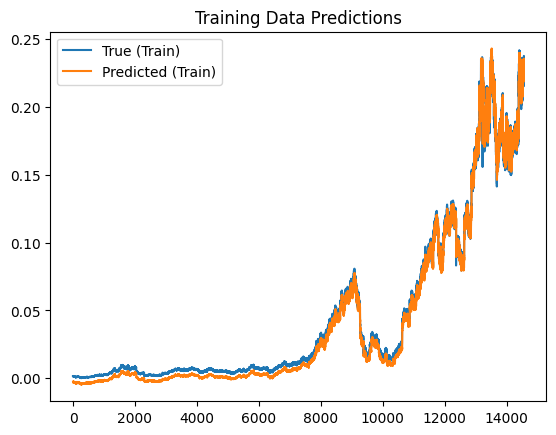

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


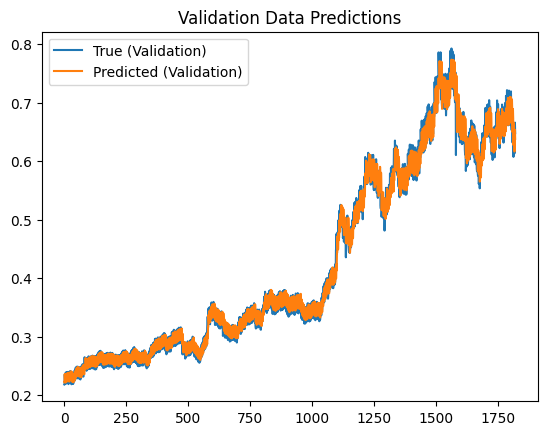

In [32]:
y_train_pred = best_model.predict(X_train)
plt.plot(y_train.flatten(), label='True (Train)')
plt.plot(y_train_pred.flatten(), label='Predicted (Train)')
plt.title('Training Data Predictions')
plt.legend()
plt.show()

y_val_pred = best_model.predict(X_val)
plt.plot(y_val.flatten(), label='True (Validation)')
plt.plot(y_val_pred.flatten(), label='Predicted (Validation)')
plt.title('Validation Data Predictions')
plt.legend()
plt.show()

In [33]:
y_pred = best_model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE: 0.01605706611781445
MAPE: 0.018393157789914252


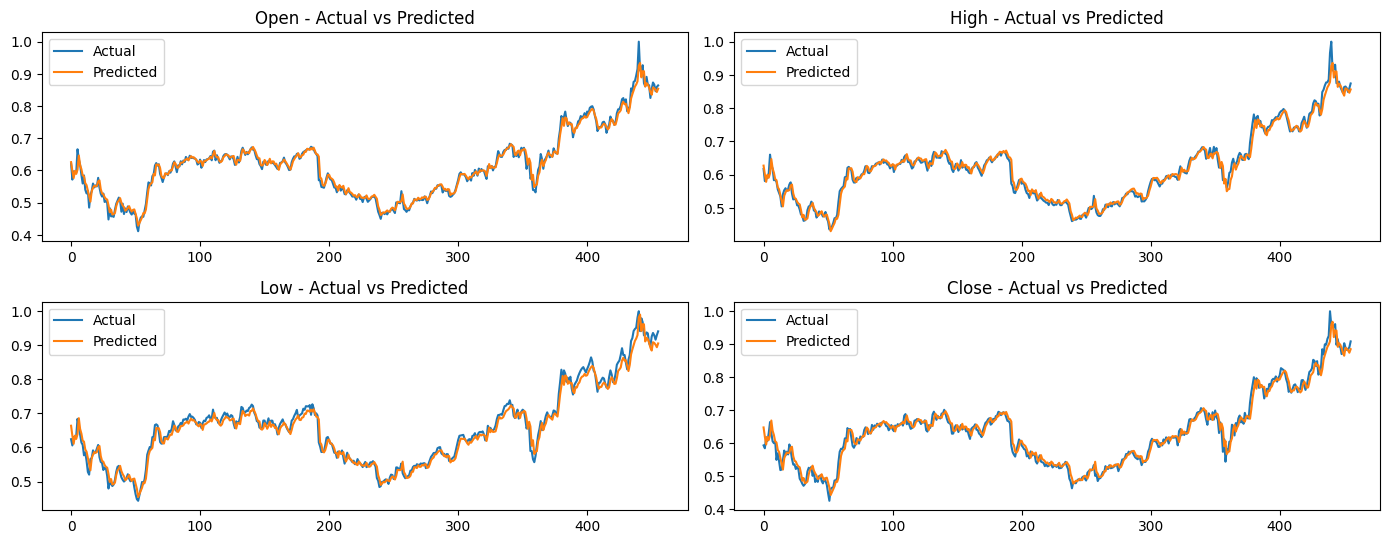

In [34]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f'{feature} - Actual vs Predicted')
    plt.legend()

plt.tight_layout()
plt.show()

Z obrázkov ale aj metrík vidíme, že náš model pekne predikuje cenu akcií na základe predchádzajúcich dát. Môžeme si všimnúť, že predikované hodnoty kopírujú skutočné hodnoty čo svedčí o tom, že model nemá underfit ani overfit.

Na ukážku nášho modelu a pre zaujímavosť sme sa rozhodli, že vyskúšame predikovať ešte na ďalšom podobnom datasete Netflixu, ktorý sme stiahli z [kaggle](https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction), ktorý má dáta od 2018 - 2022 pričom zhodné dáta s naším pôvodným datasetom sme vymazali.

In [35]:
df_netflix_new = pd.read_csv("netflix-stock-price-prediction-2020-2022-test/NFLX.csv")
df_netflix_new['Date'] = pd.to_datetime(df_netflix_new['Date'])
df_netflix_new.set_index('Date', inplace=True)

In [36]:
(df_netflix_new['Close'] == df_netflix_new['Adj Close']).all()

np.True_

In [37]:
df_netflix_new = df_netflix_new.drop(columns=['Adj Close'])

In [38]:
df_netflix_new.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-04,498.649994,510.440002,498.649994,509.640015,5608000
2020-08-05,508.679993,510.100006,501.200012,502.109985,4308200
2020-08-06,504.109985,510.820007,498.700012,509.079987,3725900
2020-08-07,505.450012,508.290009,486.679993,494.730011,5910300
2020-08-10,493.350006,497.459991,478.630005,483.380005,4691200


In [39]:
df_netflix_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 381 entries, 2020-08-04 to 2022-02-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    381 non-null    float64
 1   High    381 non-null    float64
 2   Low     381 non-null    float64
 3   Close   381 non-null    float64
 4   Volume  381 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 17.9 KB


In [40]:
df_netflix_new.describe()

,Open,High,Low,Close,Volume
count,381.000000,381.000000,381.000000,381.000000,3.810000e+02
mean,538.331942,545.371363,530.574463,537.911810,4.817670e+06
std,58.571066,58.627017,58.447036,58.392908,4.603815e+06
min,378.269989,382.660004,351.459991,359.700012,1.144000e+06
25%,501.029999,506.369995,493.500000,500.029999,2.826100e+06
50%,522.000000,531.989990,516.979980,523.890015,3.755600e+06
75%,562.500000,567.159973,553.460022,559.070007,5.132500e+06
max,692.349976,700.989990,686.090027,691.690002,5.890430e+07


In [41]:
df_netflix_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [42]:
features = ['Open', 'High', 'Low', 'Close']
scaler = MinMaxScaler()
df_netflix_new_scaled = scaler.fit_transform(df_netflix_new[features])
X_new, y_new = [], []
for i in range(30, len(df_netflix_new_scaled)):
    X_new.append(df_netflix_new_scaled[i-30:i])
    y_new.append(df_netflix_new_scaled[i])
X_new, y_new = np.array(X_new), np.array(y_new)

In [43]:
y_new_pred = best_model.predict(X_new)
y_new_pred_inverse = scaler.inverse_transform(y_new_pred)
y_new_inverse = scaler.inverse_transform(y_new)
new_rmse = np.sqrt(np.mean((y_new_pred_inverse - y_new_inverse) ** 2))
new_mape = mean_absolute_percentage_error(y_new_inverse, y_new_pred_inverse)
print(f"New Data RMSE: {new_rmse}")
print(f"New Data MAPE: {new_mape}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
New Data RMSE: 12.63449656678803
New Data MAPE: 0.014935932818807935


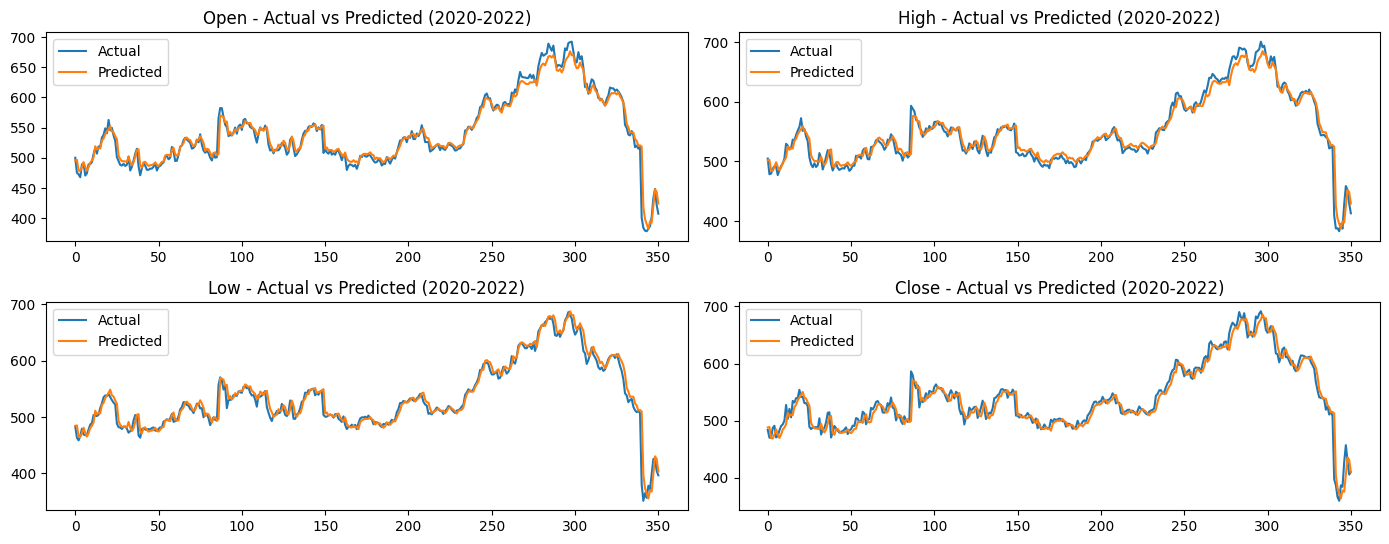

In [44]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.plot(y_new_inverse[:, i], label='Actual')
    plt.plot(y_new_pred_inverse[:, i], label='Predicted')
    plt.title(f'{feature} - Actual vs Predicted (2020-2022)')
    plt.legend()

plt.tight_layout()
plt.show()

Na záver si môžeme všimnúť že náš model je relatívne schopný predikovať aj na takýchto dátach, avšak vidíme že metriky ukazujú vačšiu chybu.

## Zdroje

Prednášky a cvičenia z predmetu IAU.

Vlastný projekt z IAU v tomto semestry.

[IAU Github repozitár](https://github.com/FIIT-IAU/IAU-course)

[Scipy dokumentácia](https://docs.scipy.org/doc/scipy/reference/index.html)

[Numpy dokumentácia](https://numpy.org/doc/)

[Pandas dokumentácia](https://pandas.pydata.org/docs/)

[Scaling](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)

[Keras dokumentácia](https://keras.io/about/)

Niektoré časti kódu boli generované pomocou `ChatGPT` a následne upravené pre naše potreby.